# Tanh Saturation Model (Pytorch - ONNX)

Simple model that learns tanh audio saturation without **tanh** activations in the model itself.  
The result is used only as an example, as using any tanh approximation or even full tanh in the code
would be considerably more efficient than executing inference of a model
  
The model is trained in pytorch and converted to ONNX

In [1]:
import numpy as np
import random
import math
# import soundfile as sf
import math
import sklearn.model_selection as sk
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import sklearn.model_selection as sk
import soundfile as sf
import onnxruntime as ort

In [2]:
saturate_sample = lambda x, g : math.tanh(g*x)
saturate_list = lambda x, g : [saturate_sample(i, g) for i in x]

## Generate dataset for fuction to learn

In [4]:
slen = 100000
# generate random list signal with slen
gensignal = np.random.rand(slen)*2 - 1
gensignal = list(gensignal)
gensignal.extend((np.random.rand(slen)*2 - 1)*0.000001)


In [5]:
X = []
y = []

for x in gensignal:
    for sat_gain in range(0,100,2):
        # small perturbation of random value between -1 and 1
        # print(sat_gain,end=" ")
        if sat_gain != 0:
            sat_gain = abs(sat_gain+np.random.uniform(-1,1))
        # print(sat_gain)
        X.append([x, sat_gain])
        y.append(saturate_sample(x,sat_gain))

In [ ]:
## Define Training parameters

In [5]:
epochs=50
# epochs=1
batch_size=2048
loss_func = 'mean_squared_error'
learning_rate=0.001
#  optimizer is Adam

In [6]:
# Split the data into training and validation sets
X_train, X_test, y_train, y_test = sk.train_test_split(X, y, test_size=0.2)

# Train the model and show with tensorboard the loss function
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


## PyTorch implementation

In [57]:
class TanhSaturation(nn.Module):
    def __init__(self):
        super(TanhSaturation, self).__init__()
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 10)
        self.layer3 = nn.Linear(10, 1)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.layer3(x)
        return x

In [9]:
class TanhDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [10]:
# Loading model
model = TanhSaturation()
print(model)

# Split the data into training and validation sets
dataset = TanhDataset(X, y)
dataset_size = len(X)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.seed(42)
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

TanhSaturation(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (activation): Sigmoid()
)


In [11]:
# Training loop

for epoch in range(epochs):
    total_loss = 0

    # Create a data loader for batch processing
    for inputs, targets in train_loader:

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.reshape(-1), targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print the average loss for the epoch
    average_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}")

torch.save(model.state_dict(), 'saturation_model.pt') # Save pytorch model just in case

KeyboardInterrupt: 

In [ ]:
# Run this only to load the Pytorch model saved, generally not needed

# del model
# model = TanhSaturation() # a torch.nn.Module object
# model.load_state_dict(torch.load('saturation_model.pt'))

In [ ]:
INPUT_SIZE = 2 #tfmodel.layers[0].get_input_at(0).get_shape().as_list()[1]
x = torch.ones(INPUT_SIZE).unsqueeze(0) # dummy input for tracing

torch.onnx.export(model,                                       # Model
                  x,                                                # Input
                  "./saturation_model.onnx",  # Output file
                  export_params=True,                               # Export trained parameters
                  do_constant_folding=True,                         # Perform constant folding
                  input_names = ['input'],                          # Label for input
                  output_names = ['output']                         # Label for output
                  ) 

## Test ONNX model

In [112]:
import onnx

# Load the ONNX model
onnxmodel = onnx.load("saturation_model.onnx")

# Check that the model is well formed
onnx.checker.check_model(onnxmodel)

# Print a human readable representation of the graph
print(onnx.helper.printable_graph(onnxmodel.graph))

graph torch-jit-export (
  %input[FLOAT, 1x2]
) initializers (
  %layer1.weight[FLOAT, 10x2]
  %layer1.bias[FLOAT, 10]
  %layer2.weight[FLOAT, 10x10]
  %layer2.bias[FLOAT, 10]
  %layer3.weight[FLOAT, 1x10]
  %layer3.bias[FLOAT, 1]
) {
  %7 = Gemm[alpha = 1, beta = 1, transB = 1](%input, %layer1.weight, %layer1.bias)
  %8 = Sigmoid(%7)
  %9 = Gemm[alpha = 1, beta = 1, transB = 1](%8, %layer2.weight, %layer2.bias)
  %10 = Sigmoid(%9)
  %output = Gemm[alpha = 1, beta = 1, transB = 1](%10, %layer3.weight, %layer3.bias)
  return %output
}


In [113]:

ort_session = ort.InferenceSession("saturation_model.onnx")

outputs = ort_session.run(
    None,
    {"input": [[0,0]]},
)
print(outputs[0])

[[-0.0006074]]


In [115]:
print("importing signal from file")
signal, sr = sf.read('./test.wav')

# # Save audio as "clean.wav"
# sf.write('clean.wav', signal, sr)

satgain = 10
# First apply saturate_list
baseline_sat_signal = saturate_list(signal, satgain)
onnx_sat_signal = []
# Then saturate with onnx model
for i in signal:
    outputs = ort_session.run(
        None,
        {"input": [[i,satgain]]},
    )
    # print(outputs[0])
    onnx_sat_signal.append(outputs[0][0])  


torch_sat_signal = []
# Then saturate with onnx model
for i in signal:
    outputs = model(torch.tensor([i, satgain], dtype=torch.float32))
    # print(outputs[0])
    # torch_sat_signal.append(outputs[0])  
    
    # Etract first element of the tensor
    torch_sat_signal.append(outputs[0].item())

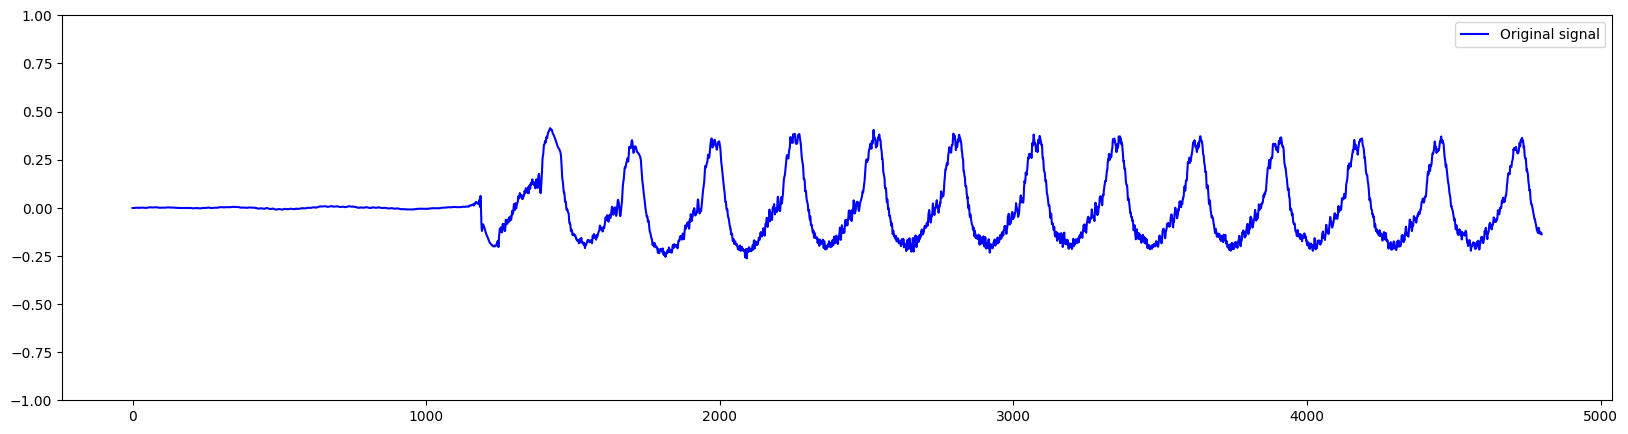

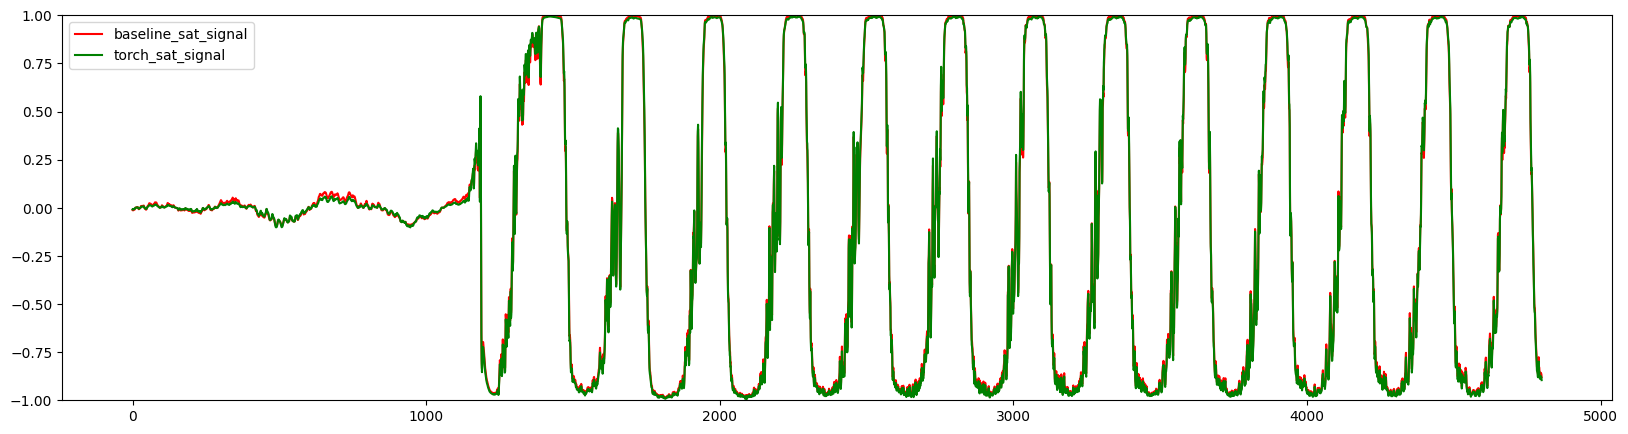

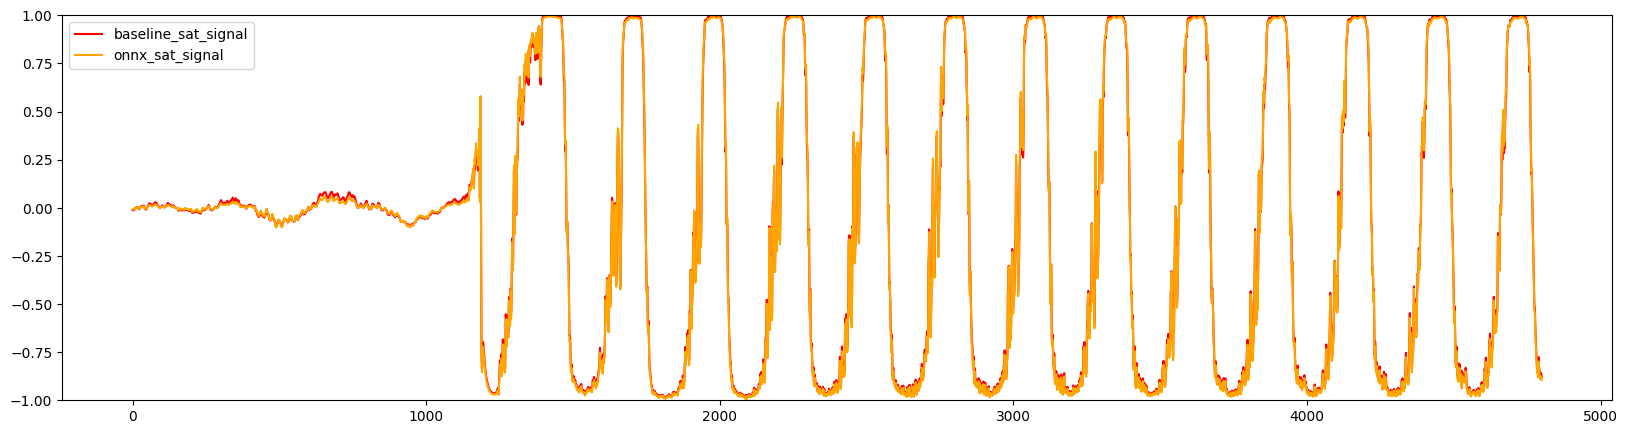

In [116]:
import matplotlib.pyplot as plt

# determine figure size 
fig = plt.figure(figsize=(20, 5))

# plot signal with ylim -1 to 1
plt.plot(signal[:], color='blue')
plt.ylim(-1,1)
plt.legend(['Original signal'])
plt.show()

# plt.line(signal[:], color='blue')

fig = plt.figure(figsize=(20, 5))
plt.ylim(-1,1)

plt.plot(baseline_sat_signal[:], color='red')
plt.plot(torch_sat_signal[:], color='green')
plt.legend(['baseline_sat_signal', 'torch_sat_signal'])
plt.show()


fig = plt.figure(figsize=(20, 5))
plt.ylim(-1,1)

plt.plot(baseline_sat_signal[:], color='red')
plt.plot(onnx_sat_signal[:], color='orange')
plt.legend(['baseline_sat_signal', 'onnx_sat_signal'])
plt.show()


# fig = plt.figure(figsize=(20, 5))
# plt.ylim(-1,1)
# # keras_sat_signal_quant

# plt.plot(keras_sat_signal[:], color='green')
# plt.plot(keras_sat_signal_quant[:], color='orange')



In [ ]:
!pip freeze > requirements.txt